In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [2]:
clean = np.loadtxt('wifi_db/clean_dataset.txt')
print(clean.shape)
noisy = np.loadtxt('wifi_db/noisy_dataset.txt')
print(noisy.shape)

(2000, 8)
(2000, 8)


### Function Declarations

In [3]:

def FIND_SPLIT(data_set: np.ndarray) -> tuple:
    '''
    The function FIND_SPLIT chooses the attribute and the value that results in the highest information gain.

    Inputs: data_set, an np.ndarray of the data set to split. The last column is assumed to be the class label
    Outputs: tuple consisting of the attribute and value to split the data for the highest information gain
    '''


    def informationGain(data_set_full: np.ndarray, data_set_left: np.ndarray, data_set_right: np.ndarray) -> float:
        '''
        informationGain takes the full data set, and the two subsets which it is divided into. It returns the information gain.

        Inputs: data_set_full, np.ndarray of full dataset
                data_set_left, np.ndarray of left subsection of dataset
                data_set_right np.ndarray of right subsection of dataset
        Outputs: float, the information gain of the sectioning
        '''
        return entropy(data_set_full) - remainder(data_set_left, data_set_right)



    def entropy(data_set: np.ndarray) -> float:
        '''
        Calculates the entropy of a dataset.

        Inputs: data_set, where column with index -1 is assumed to be the label
        Outputs: float, the entropy of the data_set
        '''
        data_set = data_set[data_set[:, -1].argsort()]
        data_labels = data_set[:,-1]
        unique_labels = np.unique(data_labels)

        probabilities = np.zeros_like(unique_labels)

        for i, label in enumerate(unique_labels):
            probabilities[i] = np.sum(data_labels == label) / len(data_labels)

        entropy = - np.sum(np.log2(probabilities) * probabilities)
        
        return entropy



    def remainder(data_set_left: np.ndarray, data_set_right: np.ndarray) -> float:
        '''
        Calculates the remainder two subsets.

        Inputs: data_set_left, np.ndarray of the left subsection
                data_set_right, np.ndarray of the right subsection

        Outputs: float, the remainder of the subsections

        '''
        no_samples_left = len(data_set_left)
        no_samples_right = len(data_set_right)
        no_samples_tot = no_samples_left + no_samples_right

        entropy_left = entropy(data_set_left)
        entropy_right = entropy(data_set_right)

        remainder = no_samples_left * entropy_left / no_samples_tot + no_samples_right * entropy_right / no_samples_tot

        return remainder
    

    attributes = data_set.shape[1] - 1

    running_score = np.zeros((attributes, 2))

    for i in range(attributes):

        highest_information_gain = 0
        best_split = None

        data_set = data_set[data_set[:, i].argsort()]
        unique_values = np.unique(data_set[:, i])
        possible_splits = (unique_values[:-1] + unique_values[1:]) / 2

        for split in possible_splits:

            left_index = data_set[:, i] > split
            right_index = left_index == False

            data_set_left = data_set[left_index]
            data_set_right = data_set[right_index]

            information_gain = informationGain(data_set, data_set_left, data_set_right)

            if information_gain > highest_information_gain:
                highest_information_gain = information_gain
                best_split = split

        running_score[i,0] = highest_information_gain
        running_score[i,1] = best_split

    attribute_to_split = np.argmax(running_score[:, 0])
    split_value = running_score[attribute_to_split, 1]

    return (attribute_to_split, split_value)



def decisionTreeLearning(train_dataset: np.ndarray, depth: int = 0, max_depth: int = 100, min_samples_leaf: int = 1):
    '''
    Takes as arguments a matrix containing the dataset and a depth variable (which is used to compute the maximal depth
    of the tree, for plotting purposes for instance). The label of the training dataset is assumed to be the last
    column of the matrix.

    Inputs: train_dataset, np.ndarray
            depth, int, to keep track of how deep down the tree the node is
            max_depth, int which can be used to regularise the classifier
            min_samples_leaf, int, the minimum samples on a node before it becomes a leaf. Used for regularisation
    Outputs: node, dictionary
             depth, int

    '''

    if len(set(train_dataset[:, -1])) == 1:
        leaf_val = train_dataset[0,-1]
        #for leaf the leaf_vale is saved under the attribute key
        leaf_node = {'attribute': None, 'value': leaf_val,
                     'left': None, 'right': None, 'isLeaf': True}
        
        return leaf_node, depth
    
    if depth >= max_depth:
        counts = np.bincount(np.int64(train_dataset[:, -1]))
        leaf_val = np.argmax(counts)

        leaf_node = {'attribute': None, 'value': leaf_val,
                     'left': None, 'right': None, 'isLeaf': True}
        return leaf_node, depth
    
    if len(train_dataset[:, -1]) <= min_samples_leaf:
        counts = np.bincount(np.int64(train_dataset[:, -1]))
        leaf_val = np.argmax(counts)

        leaf_node = {'attribute': None, 'value': leaf_val,
                        'left': None, 'right': None, 'isLeaf': True}
        return leaf_node, depth 

    attribute, value = FIND_SPLIT(train_dataset)

    node = {'attribute': attribute, 'value': value, 'left': None, 'right': None, 'isLeaf': False}
   
    l_dataset = train_dataset[train_dataset[:, attribute] <= value]
    node['left'], l_depth = decisionTreeLearning(l_dataset, depth = depth+1, max_depth = max_depth, min_samples_leaf = min_samples_leaf) #shoud we sort this?

    r_dataset = train_dataset[train_dataset[:, attribute] > value]
    node['right'], r_depth = decisionTreeLearning(r_dataset, depth = depth+1, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
   
    return node, max(l_depth, r_depth)



def sampleClassification(root: dict, sample: np.ndarray) -> int:
    '''
    Classifies a sample using the decision tree

    Inputs: root, dictionary containing the root of the tree
            sample, np.ndarray containing the sample features
    Outputs: integer label for the sample
    '''
   
    if root['isLeaf']:
        #do the return instead of print int he future
        return root['value']
   
    col = root['attribute']
    val = root['value']

    if sample[col] <= val:
        return sampleClassification(root['left'], sample)
    else:
        return sampleClassification(root['right'], sample)


def decisionTreeClassifier(x_test, root):
    '''
    Takes a whole dataset and the root of the decision tree and labels each point. 
    Assumes the last column is true labels.

    Inputs: x_test, np.ndarray matrix containing test data
            root, dictionary containing the root of the decision tree
    Outputs: np.ndarray containing the predicted labels
    '''
    
    predictions = np.zeros(len(x_test))

    for i in range(len(x_test)):
        predictions[i] = sampleClassification(root, x_test[i,:-1])
    
    return predictions


 # TODO
def printTree(root, depth):
    'bonus question to print the tree, BFS based '
    np.full((2**depth),' ')
    pass

### Train/Test the tree on the clean data

In [4]:
root, _ = decisionTreeLearning(clean)
clean_pred = decisionTreeClassifier(clean, root)

### Test tree on noisy data

In [5]:
noisy_pred = decisionTreeClassifier(noisy, root)
accuracy = np.sum(noisy_pred == noisy[:,-1]) / len(noisy)
print('The accuracy on the testing data is: {}'.format(accuracy))

The accuracy on the testing data is: 0.918


# Evaluation Functions


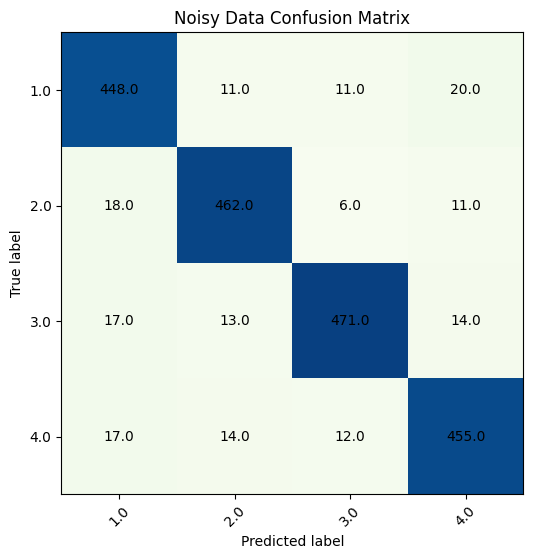

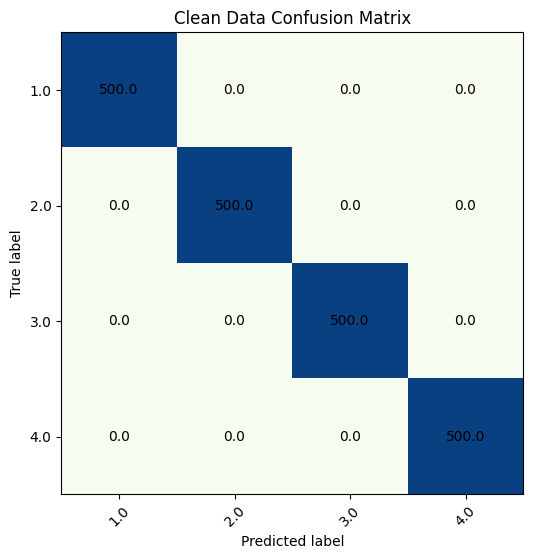

In [6]:
# Confusion Matrix

def plot_confusion_matrix(cm, class_labels, title):
  '''
    Takes a numpy array format of the confusion matrix and plots it neatly
    using matplotlib.

    Inputs: cm - array containing confusion matrix
            class_labels - list containing axis titles
            title - string containing title for cm
    Outputs: plots a confusion matrix
    '''
  plt.figure(figsize=(8,6))
  plt.imshow(cm, cmap = "GnBu")
  plt.title(title + ' Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(class_labels))
  plt.xticks(tick_marks, class_labels, rotation=45)
  plt.yticks(tick_marks, class_labels)
  for (j, i), label in np.ndenumerate(cm):
      plt.text(i, j, label, ha='center', va='center')
  plt.show()

def confusion_matrix(y_true, y_prediction, class_labels = []):
  '''
    Uses true and predicted values to calculate the confusion matrix.

    Inputs: y_true - array containing all the true labels
            y_pred - array containing all the predicted labels
    
    Outputs: cm - array containing the confusion matrix
             class_labels - appropriate labels for rows/column of matrix, useful for plotting
  '''
  if len(class_labels) <1:
    class_labels = np.unique(np.concatenate((y_true, y_prediction)))
  cm = np.zeros((len(class_labels), len(class_labels)))
  for (i, i_label) in enumerate(class_labels):
    true_index = (y_true == i_label)
    true = y_true[true_index]
    predictions = y_prediction[true_index]
    (unique_labels, counts) = np.unique(predictions, return_counts=True)
    cm_data = dict(zip(unique_labels, counts))

    for (j, j_label) in enumerate(class_labels):
      cm[i, j] = cm_data.get(j_label, 0)

  return cm, class_labels

cleany_true = clean[:, -1]
noisyy_true = noisy[:, -1]
class_labels = np.unique(np.concatenate((noisyy_true, noisy_pred)))
noisy_cm, class_labels = confusion_matrix(noisyy_true, noisy_pred, class_labels)
plot_confusion_matrix(noisy_cm, class_labels, "Noisy Data")

clean_cm, class_labels = confusion_matrix(cleany_true, clean_pred)
plot_confusion_matrix(clean_cm, class_labels, "Clean Data")


In [7]:
# Metrics

# Accuracy

def accuracy(cm):
    '''
      Computes the accuracy of the decision tree using the confusion matrix

      Inputs: cm - array containing the confusion matrix
      
      Outputs: np.sum(np.diag(cm)) / np.sum(cm) - The decision tree accuracy
              0 - if there is no cm the function simply returns 0
    '''
    if np.sum(cm) > 0:
      return np.sum(np.diag(cm)) / np.sum(cm)
    else:
      return 0

# Precision

def precision(cm):
  ''' 
    Computes the class precisions and macro precision of the decision tree using the confusion matrix
  
    Inputs: cm - array containing the confusion matrix

    Outputs: (p, macro_p) - tuple containing the class precisions as an array and the macro precision as a float
  '''
  p = np.zeros((len(cm)))
  for c in range(len(cm)):
    if np.sum(cm[:, c]) > 0:
      p[c] = cm[c, c] / np.sum(cm[:, c])
  macro_p = 0
  if len(p) > 0:
    macro_p = np.mean(p)
  return (p, macro_p)

# Recall

def recall(cm):
  ''' 
    Computes the class recall and macro recall of the decision tree using the confusion matrix
  
    Inputs: cm - array containing the confusion matrix

    Outputs: (r, macro_r) - tuple containing the class recall as an array and the macro recall as a float
  '''
  r = np.zeros((len(cm)))
  for c in range(len(cm)):
    if np.sum(cm[:, c]) > 0:
      r[c] = cm[c, c] / np.sum(cm[c, :])
  macro_r = 0
  if len(r) > 0:
    macro_r = np.mean(r)

  return (r, macro_r)

# F1 Measures

def f_measure(cm, beta=1):
  ''' 
    Computes the class f-measure and macro f-measure of the decision tree using the confusion matrix
  
    Inputs: cm - array containing the confusion matrix

    Outputs: (p, macro_p) - tuple containing the class precisions as an array and the macro precision as a float
  '''
  (precisions, macro_p) = precision(cm)
  (recalls, macro_r) = recall(cm)
  assert len(precisions) == len(recalls)
  f = np.zeros((len(precisions)))
  for c, (p, r) in enumerate(zip(precisions, recalls)):
    if p + r > 0:
      f[c] = (1 + beta**2) * p * r / ((beta**2 * p) + r)
  macro_f = 0
  if len(f) > 0:
    macro_f = np.mean(f)
  return (f, macro_f)


In [8]:
# Tests

# clean
print("Clean Data")
print("Accuracy: " + str(accuracy(clean_cm)))
print("Precision: " + str(precision(clean_cm)))
print("Recall: " + str(recall(clean_cm)))
print("F-measure: " + str(f_measure(clean_cm)))

# noisy
print("\n\nNoisy Data")
print("Accuracy: " + str(accuracy(noisy_cm)))
print("Precision: " + str(precision(noisy_cm)))
print("Recall: " + str(recall(noisy_cm)))
print("F-measure: " + str(f_measure(noisy_cm)))





Clean Data
Accuracy: 1.0
Precision: (array([1., 1., 1., 1.]), 1.0)
Recall: (array([1., 1., 1., 1.]), 1.0)
F-measure: (array([1., 1., 1., 1.]), 1.0)


Noisy Data
Accuracy: 0.918
Precision: (array([0.896, 0.924, 0.942, 0.91 ]), 0.918)
Recall: (array([0.91428571, 0.92957746, 0.91456311, 0.91365462]), 0.9180202260861148)
F-measure: (array([0.90505051, 0.92678034, 0.92807882, 0.91182365]), 0.9179333277755386)


In [9]:

#  K-fold cross-validation
from numpy.random import default_rng

# First split the dataset equally - uses indices rather than the dataset itself
def k_fold_split(no_splits, row_count, random_generator=default_rng()):

    # generate a random permutation of indices from 0 to n_instances
    shuffled_indices = random_generator.permutation(row_count)

    # split shuffled indices into almost equal sized splits
    split_indices = np.array_split(shuffled_indices, no_splits)

    return split_indices

# We then need to produce 10 train/test splits for each fold, using one of the
# splits for testing each time, and the remainders for testing.

def train_test_k_fold(no_folds, no_instances, random_generator=default_rng()):
  split_indices = k_fold_split(no_folds, no_instances, random_generator)

  fold_indices = []
  for k in range(no_folds):
      test_indices = split_indices[k]
      train_indices =  np.concatenate(split_indices[0:k] + split_indices[k+1:])
      fold_indices.append([train_indices, test_indices])
  return fold_indices


In [11]:


def train_n_evaluate_unsplit(dataset, dataset_label="Unknown"):
    n_folds = 10
    accuracies = np.zeros((n_folds, ))
    X,y = dataset[:,:-1], dataset[:, -1]

    for i, (train_indices, test_indices) in enumerate(train_test_k_fold(n_folds, len(X), random_generator=default_rng())):
        training_dataset = dataset[train_indices]
        testing_dataset = dataset[test_indices]
        y_test = y[test_indices]

        # Here i equates to the fold, and I will take the average across all of these folds
        # Train decision tree
        root, _ = decisionTreeLearning(training_dataset)
        y_pred = decisionTreeClassifier(testing_dataset, root)

        # Make confusion matrix
        cm, class_labels = confusion_matrix(y_test, y_pred)

        # Compute accuracy
        accuracies[i] = accuracy(cm)


    print(f"{dataset_label} accuracies: ", accuracies)
    print(f"{dataset_label} accuracies.mean(): ", accuracies.mean())
    print(f"{dataset_label} accuracies.std(): ", accuracies.std())

    return accuracies, accuracies.mean(), accuracies.std()

clean_accuracy_unsplit = train_n_evaluate_unsplit(clean, "Clean")
noisy_accuracy_unsplit = train_n_evaluate_unsplit(noisy, "Noisy")


Clean accuracies:  [0.98  0.98  0.96  0.98  0.955 0.96  0.97  0.96  0.99  0.975]
Clean accuracies.mean():  0.9709999999999999
Clean accuracies.std():  0.011135528725660053
Noisy accuracies:  [0.83  0.755 0.785 0.775 0.765 0.84  0.745 0.79  0.81  0.795]
Noisy accuracies.mean():  0.789
Noisy accuracies.std():  0.029393876913398124


In [12]:
# 𝑘-fold cross validation with hyperparameter tuning - i.e. now splitting data, and doing a validation set split too
def train_val_test_k_fold(no_folds, no_instances, random_generator=default_rng()):
  split_indices = k_fold_split(no_folds, no_instances, random_generator)

  folds = []
  for k in range(no_folds):
      test_indices = split_indices[k]
      validation_indices = split_indices[(k+1) % no_folds]
      train_indices = np.concatenate([split_indices[x] for x in range(no_folds) if x != k and x != (k+1) % no_folds])
      folds.append([train_indices, validation_indices, test_indices])
  return folds

print("train_val_test_k_fold(10, 30, default_rng()): ", train_val_test_k_fold(10, 30, default_rng()))

# # to test function (30 instances, 4 fold)
# for (train_indices, validation_indices, test_indices) in train_val_test_k_fold(10, 30, default_rng()):
#     print("train: ", train_indices)
#     print("validation: ", validation_indices)
#     print("test: ", test_indices)
#     print()

train_val_test_k_fold(10, 30, default_rng()):  [[array([ 8, 17, 16, 28,  9, 22,  1, 24, 12, 27,  4, 23, 26, 18, 21, 19,  0,
       13, 14, 29,  5, 25, 15,  3]), array([ 7,  6, 11]), array([20,  2, 10])], [array([20,  2, 10, 28,  9, 22,  1, 24, 12, 27,  4, 23, 26, 18, 21, 19,  0,
       13, 14, 29,  5, 25, 15,  3]), array([ 8, 17, 16]), array([ 7,  6, 11])], [array([20,  2, 10,  7,  6, 11,  1, 24, 12, 27,  4, 23, 26, 18, 21, 19,  0,
       13, 14, 29,  5, 25, 15,  3]), array([28,  9, 22]), array([ 8, 17, 16])], [array([20,  2, 10,  7,  6, 11,  8, 17, 16, 27,  4, 23, 26, 18, 21, 19,  0,
       13, 14, 29,  5, 25, 15,  3]), array([ 1, 24, 12]), array([28,  9, 22])], [array([20,  2, 10,  7,  6, 11,  8, 17, 16, 28,  9, 22, 26, 18, 21, 19,  0,
       13, 14, 29,  5, 25, 15,  3]), array([27,  4, 23]), array([ 1, 24, 12])], [array([20,  2, 10,  7,  6, 11,  8, 17, 16, 28,  9, 22,  1, 24, 12, 19,  0,
       13, 14, 29,  5, 25, 15,  3]), array([26, 18, 21]), array([27,  4, 23])], [array([20,  2, 

In [ ]:
# For each fold, we will perform a grid search to search for the hyperparameter value that optimises
# the performance of the model on the validation set. We should then evaluate this model on the
# test set, and average the score across folds, arbitrarily using the accuracy metric but it's
# recommended to use more than 1

def final_parameter_optimisation(dataset):
  n_folds = 10
  accuracies = np.zeros((n_folds, ))
  best_parameter_per_fold = np.zeros((n_folds,))

  hyperparameter_values = list(range(0, 10))
  hyperparameter_accuracies = np.zeros((n_folds, len(hyperparameter_values)+1))

  test_accuracies = np.zeros((n_folds,))
  X,y = dataset[:,:-1], dataset[:, -1]

  # train_val_test_k_fold() returns the sets of training, validation and testing indices for each fold 
  for k, (train_indices, validation_indices, test_indices) in enumerate(train_val_test_k_fold(n_folds, len(X))):
      # Set up the dataset for this fold
      y_validation = y[validation_indices]
      y_test = y[test_indices]

      training_dataset = dataset[train_indices]
      validation_dataset = dataset[validation_indices]
      testing_dataset = dataset[test_indices]

      # Perform grid search, we - group - need to identify our parameter and the range we want it to span
      for parameter in hyperparameter_values:
        # # Train decision tree & predict/evaluate on our validation set     
        root, _ = decisionTreeLearning(training_dataset)
        y_pred = decisionTreeClassifier(validation_dataset, root)

        # Evaluate validation data with confusion matrix
        cm, class_labels = confusion_matrix(y_validation, y_pred)
        hyperparameter_accuracies[k][parameter] = accuracy(cm)

      # Store the parameter/classifier with the highest accuracy out of the parameters traversed in this fold. 
      best_parameter_index = np.argmax(hyperparameter_accuracies[k])
      best_parameter_per_fold[k] = hyperparameter_values[best_parameter_index]

      # Test the Best Model
      # Train on combined train + validation data
      combined_dataset = np.concatenate((training_dataset, validation_dataset))

      # NOTE We need to modify decisionTreeLearning to accept a hyperparameter, and ensure the model behaves
      # differently for different values of that hyperparameter.
      # best_param = best_parameter_per_fold[k]
      # root, _ = decisionTreeLearning(combined_dataset, best_param)

      root, _ = decisionTreeLearning(combined_dataset)
      
      # Evaluate this classifier on x_test (accuracy)
      final_y_pred = decisionTreeClassifier(testing_dataset, root)

      final_cm, _ = confusion_matrix(y_test, final_y_pred)
      test_accuracies[k] = accuracy(final_cm)

  print("hyperparameter_accuracies :")
  print(hyperparameter_accuracies)

  print("\nbest_parameter_per_fold:")
  print(best_parameter_per_fold)

  print("\ntest_accuracies")
  print(test_accuracies)
  
  # No return in this function yet either 


clean_parameter_outputs = final_parameter_optimisation(clean)
noisy_parameter_outputs = final_parameter_optimisation(noisy)


hyperparameter_accuracies :
[[0.    0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98 ]
 [0.    0.97  0.97  0.97  0.97  0.97  0.97  0.97  0.97  0.97  0.97 ]
 [0.    0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975]
 [0.    0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98 ]
 [0.    0.965 0.965 0.965 0.965 0.965 0.965 0.965 0.965 0.965 0.965]
 [0.    0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98 ]
 [0.    0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975]
 [0.    0.93  0.93  0.93  0.93  0.93  0.93  0.93  0.93  0.93  0.93 ]
 [0.    0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98 ]
 [0.    0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.98 ]]

best_parameter_per_fold:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

test_accuracies
[0.98  0.985 0.965 0.985 0.975 0.955 0.985 0.97  0.955 0.975]
hyperparameter_accuracies :
[[0.    0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805]
 [0.    0.84  0.84  0.84  0.84  0.84  0.84  0.8